In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import

In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 8.1MB/s 


In [0]:
import numpy as np                                                              
import pandas as pd                                                             
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf                                                         #GPU 확인

device_name = tf.test.gpu_device_name()                                         #사용하는 장치 이름 호출
if device_name != '/device:GPU:0':                                              #!= 의 뜻: ~가 아니다
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           #multi GPU 관련 코드로 추측
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Data Set

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/train_netflix_82400_binary_edit.csv")

In [0]:
train

SentenceId                                             Phrase  Sentiment
0               1  I think this app is great. I can always find s...        1.0
1               2  You should not be able to access account setti...        0.0
2               3  Love the app. Especially the download feature....        1.0
3               4  Great I love this app.... it's only that you w...        1.0
4               5  I registered for the first time for a free 30 ...        0.0
...           ...                                                ...        ...
58890       58891        It's amazing app for binge watching video!!        1.0
58891       58892  They got quite good collection of series & mov...        1.0
58892       58893                                 App is not working        0.0
58893       58894  The TV shows need to be updated like criminal ...        0.0
58894       58895  Love how they put new movies and old very happ...        1.0

[58895 rows x 3 columns]

In [0]:
train.dropna(inplace=True)                                                      
train['Sentiment'] = train.Sentiment.astype(int)                                                         

In [0]:
train                                                                    

SentenceId                                             Phrase  Sentiment
0               1  I think this app is great. I can always find s...          1
1               2  You should not be able to access account setti...          0
2               3  Love the app. Especially the download feature....          1
3               4  Great I love this app.... it's only that you w...          1
4               5  I registered for the first time for a free 30 ...          0
...           ...                                                ...        ...
58890       58891        It's amazing app for binge watching video!!          1
58891       58892  They got quite good collection of series & mov...          1
58892       58893                                 App is not working          0
58893       58894  The TV shows need to be updated like criminal ...          0
58894       58895  Love how they put new movies and old very happ...          1

[58895 rows x 3 columns]

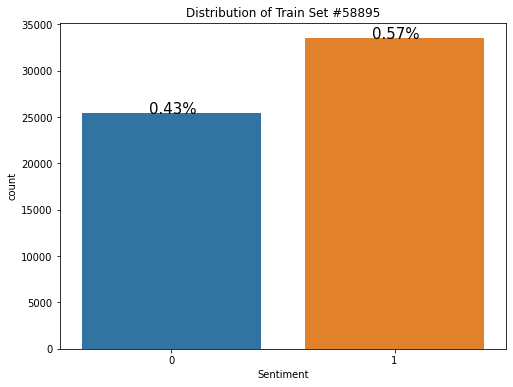

In [0]:
plt.figure(figsize=(8, 6))
plt.title("Distribution of Train Set #%.f" %len(train))
ax=sns.countplot(x="Sentiment", data=train)

for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()/len(train)), (p.get_x()+0.3, p.get_height()),fontsize=15)

In [0]:
train.Sentiment.value_counts()

1    33499
0    25396
Name: Sentiment, dtype: int64

In [0]:
train.shape

(58895, 3)

In [0]:
train['Sentiment'].unique()

array([1, 0])

# Tokenizer

In [0]:
sentences = train.Phrase.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]          #BERT를 원활히 사용하기 위해 special token 앞 뒤에 추가
labels = train.Sentiment.values

In [0]:
sentences

["[CLS] I think this app is great. I can always find something new to watch that isn't aired on TV. Sometimes you will find that a show or movie you are looking for is not on Netflix but if you email the company and request for that show or that kind of show to be added, eventually you will see it pop up. P...Full Review [SEP]",
 "[CLS] You should not be able to access account settings from this app. At the very least it should ask you to login once it's opened the browser page but as it is it's really insecure. 2 factor authentication should be required when logging in from a new device. I can't believe that an app this popular fr...Full Review [SEP]",
 '[CLS] Love the app. Especially the download feature. I can watch my favorite movies and series on the road! Also when there is no internet!!! It is so easy to make an account. The only thing that can be better is the subtitles. One than more timez the subtitles have random words that are not what the char...Full Review [SEP]',
 "[CLS]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]              #각 문장별 tokenize
print ("첫문장 Tokenize\n")
print (train.Phrase[0])
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 904781.32B/s]


첫문장 Tokenize

I think this app is great. I can always find something new to watch that isn't aired on TV. Sometimes you will find that a show or movie you are looking for is not on Netflix but if you email the company and request for that show or that kind of show to be added, eventually you will see it pop up. P...Full Review
['[CLS]', 'i', 'think', 'this', 'app', 'is', 'great', '.', 'i', 'can', 'always', 'find', 'something', 'new', 'to', 'watch', 'that', 'isn', "'", 't', 'aired', 'on', 'tv', '.', 'sometimes', 'you', 'will', 'find', 'that', 'a', 'show', 'or', 'movie', 'you', 'are', 'looking', 'for', 'is', 'not', 'on', 'netflix', 'but', 'if', 'you', 'email', 'the', 'company', 'and', 'request', 'for', 'that', 'show', 'or', 'that', 'kind', 'of', 'show', 'to', 'be', 'added', ',', 'eventually', 'you', 'will', 'see', 'it', 'pop', 'up', '.', 'p', '.', '.', '.', 'full', 'review', '[SEP]']


In [0]:
# for tokenized_text in tokenized_texts:                                          #길이가 길지만 영양가 없는 리뷰 확인
#   if len(tokenized_text)>128:
#     print(tokenized_text)

In [0]:
MAX_LEN = 128                                                                    #64보다 벗어난 리뷰 길이 편집 후 special token 붙이기
length_edit=[]
for tokenized_text in tokenized_texts:
  if len(tokenized_text) >MAX_LEN-1:
    cut=tokenized_text[:MAX_LEN-1]
    cut.append(tokenized_text[-1])
    length_edit.append(cut)
  else:
    length_edit.append(tokenized_text)
tokenized_texts=length_edit

In [0]:
train.Phrase.apply(lambda x: len(x.split()))

0        64
1        58
2        58
3        64
4        59
         ..
58890     7
58891     9
58892     4
58893    40
58894    13
Name: Phrase, Length: 58895, dtype: int64

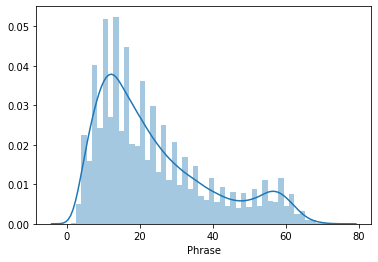

In [0]:
sns.distplot(train.Phrase.apply(lambda x: len(x.split())))                      #띄어쓰기로 나눴을때 그 단어 개수

# Padding

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
print("원래 문장 \n",tokenized_texts[6])

print("\ntokenizer후 \n",tokenizer.convert_tokens_to_ids(tokenized_texts[6]))                      #단어 → 숫자

print("\n수열형태 \n",pad_sequences([tokenizer.convert_tokens_to_ids(tokenized_texts[6])]))     #수열 형태로 변환 

print("\n 패딩 완료 \n",pad_sequences([tokenizer.convert_tokens_to_ids(tokenized_texts[6])],      
              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")) #단어 최대 64개(maxlen)로 자름(truncating) 그보다 짧으면 다 0으로처리(padding), 

원래 문장 
 ['[CLS]', 'awesome', ',', 'joy', '##ful', ',', 'and', 'pleasant', '!', 'netflix', 'really', 'did', 'an', 'amazing', 'job', 'with', 'their', 'business', '.', 'i', 'immediately', 'got', 'hooked', ',', 'and', 'my', 'favourite', 'parts', 'are', 'where', 'you', 'only', 'need', 'one', 'account', 'for', 'all', 'family', 'members', 'to', 'access', 'separate', 'users', ',', 'and', 'the', 'fact', 'there', 'is', 'unlimited', 'series', 'and', 'films', 'from', 'across', 'the', 'world', '!', '[SEP]']

tokenizer후 
 [101, 12476, 1010, 6569, 3993, 1010, 1998, 8242, 999, 20907, 2428, 2106, 2019, 6429, 3105, 2007, 2037, 2449, 1012, 1045, 3202, 2288, 13322, 1010, 1998, 2026, 8837, 3033, 2024, 2073, 2017, 2069, 2342, 2028, 4070, 2005, 2035, 2155, 2372, 2000, 3229, 3584, 5198, 1010, 1998, 1996, 2755, 2045, 2003, 14668, 2186, 1998, 3152, 2013, 2408, 1996, 2088, 999, 102]

수열형태 
 [[  101 12476  1010  6569  3993  1010  1998  8242   999 20907  2428  2106
   2019  6429  3105  2007  2037  2449  1012  1045

# Attention Mask

In [0]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]                                          #각 데이터에 숫자가 있으면 1 없으면 0 으로 1,0으로 이루어진 벡터로 변환 ex) [50,1,3,0,0,1]→[1,1,1,0,0,1]
  attention_masks.append(seq_mask)                                              #bert에서 모델이 신경쓸 인풋들을 표현하기 위한 인수

In [0]:
print(attention_masks[6])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Train, Validation split

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels,train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks, 
                                                            random_state=2020, test_size=0.1)
                                                                                # input_ids: 단어들 tokenize 해서 index화 시킨것들 128*1
                                                                                # labels: sentiment 지수
                                                                                # attention_masks: 문장에서 단어가 있으면 1 없으면 0 으로 시킨것 32*1

In [0]:
print("Input 인자들")
print("\ntokenizer후 \n",train_inputs[0])                     
print("\n평가 지수 \n", train_labels[0])      
print("\n패딩 완료 \n", train_masks[0])

Input 인자들

tokenizer후 
 [  101  1037  2210  6314  2008 20907  2038  3718  3056  1000  5805  1000
  3065  1006 16436  4230  1007  2138  1997  1037  2261 15807 13373  2666
  1012  2004  2619  2040  2573  1999  2740  2729  1010  1045  2001 24256
  7568  2000  2424  2107  1037  6851  1998 12367  8082  2265  1012  1045
  2001  2059  3811  9364  2012  2049  8208  2138  1037  2261  3180 21877
  2080  1012  1012  1012  2440  3319   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]

평가 지수 
 0

패딩 완료 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

# Tensorflow & DataLoader

In [0]:
train_inputs = torch.tensor(train_inputs)                                       #데이터 입력형 변환
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32                                                                 #일반적으로 16,32 사용
                                                                                #DataLoader 사용함으로써 training 중 전체 데이터를 불러오지 않기에 메모리 절약의 이점이 있음
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)                                       #sampler 는 index를 랜덤하게 가져온다
train_dataloader = DataLoader(train_data, sampler=train_sampler,                #데이터가 크기에 batch size 만큼씩 넣어서 처리함
                              batch_size=batch_size)                            #ex) batch size2로 할시 (train_inputs 2개, train_masks 2개, train_labels 2개)가 한묶음
                                                                                
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler,
                                   batch_size=batch_size)


# Model

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",      #single linear classification layer가 위에 있는 모델
                                                      num_labels=2)             #분류해야할게 5가지 이기 때문에 num_labels=5
model.cuda()                                                                    #GPU 사용해서 할때 필요한 함수

100%|██████████| 407873900/407873900 [00:12<00:00, 31800664.76B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())                                #레이어 등등의 pretrained 파라미터 값들
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [                                                #두가지의 파라미터 그룹으로 나눠짐
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# optimizer_grouped_parameters

In [0]:
optimizer = BertAdam(optimizer_grouped_parameters,                              #training에 필요한 모든 hyperparameter들의 정보를 갖고 있음?
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
optimizer

BertAdam (
Parameter Group 0
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 2e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7f368a13f6a0>
    weight_decay: 0.01
    weight_decay_rate: 0.01

Parameter Group 1
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 2e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7f368a13f6a0>
    weight_decay: 0.01
    weight_decay_rate: 0.0
)

In [0]:
def flat_accuracy_mse(preds, labels):                                           #정확도와 mse를 계산하는 함수
    pred_flat = np.argmax(preds, axis=1).flatten()                              #행별로 가장 큰 값의 index를 반환 → 가장 확률 높은 classification
    labels_flat = labels.flatten()
    tmp_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    tmp_mse = mean_squared_error(pred_flat, labels_flat) 
    return tmp_accuracy, tmp_mse                                                #예측값과 라벨값이 같은것들을 전체 데이터수로 평균= accuracy
                                                                                #batch가 있기에 여러개를 한꺼번에 accuracy 계산

# Training

In [0]:
train_loss_set = []                                                             

epochs = 2                                                                      #일반적으로 2,4 추천

for _ in trange(epochs, desc="Epoch"):                                          #tqdm: for 문의 진행상황을 보여줌, trange: tqdm 을 활용한 range  이름은 Epoch으로 나옴  
  
  # Training
  
  # 학습모드로 변경
  model.train()                                                                 
  
  # 추적 변수
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):                               #(순서, 값)
    batch = tuple(t.to(device) for t in batch)                                  # batch를 GPU로
    b_input_ids, b_input_mask, b_labels = batch                                 # Dataloader에서 값 끌고오기
    optimizer.zero_grad()                                                       # 이유: https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
    # 순전파
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels) #loss 반환
    train_loss_set.append(loss.item())    
    # 역전파
    loss.backward()
    # 파라미터 업데이트
    optimizer.step()
   
    # 추적 변수 업데이트
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # 평가모드로 변경
  model.eval()

  # 추적 변수
  eval_mse, eval_accuracy = 0, 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:                                           
    predictions = []
    batch = tuple(t.to(device) for t in batch)                                  # batch를 GPU로
    b_input_ids, b_input_mask, b_labels = batch                                 # Dataloader에서 값 끌고오기
    with torch.no_grad():                                                       # gradients 계산하거나 저장하게 하지 않음으로써 메모리 절약과 평가속도 향상
      # 순전파
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) # 각 class 별 확률을 반환, index가 0~4 = 각 점수
    
    # 나온 값을 CPU로 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy,tmp_eval_mse = flat_accuracy_mse(logits, label_ids)                        
    
    eval_accuracy += tmp_eval_accuracy
    eval_mse += tmp_eval_mse

    nb_eval_steps += 1
    
  print("Validation Accuracy: {}  Validation RMSE: {}".format(eval_accuracy/nb_eval_steps,(eval_mse/nb_eval_steps)**0.5))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.23711735042521373


Epoch:  50%|█████     | 1/2 [23:33<23:33, 1414.00s/it]

Validation Accuracy: 0.9192567567567568  Validation RMSE: 0.2841535557462606
Train loss: 0.16735112928101364


Epoch: 100%|██████████| 2/2 [47:24<00:00, 1422.24s/it]

Validation Accuracy: 0.920777027027027  Validation RMSE: 0.2814657580825294


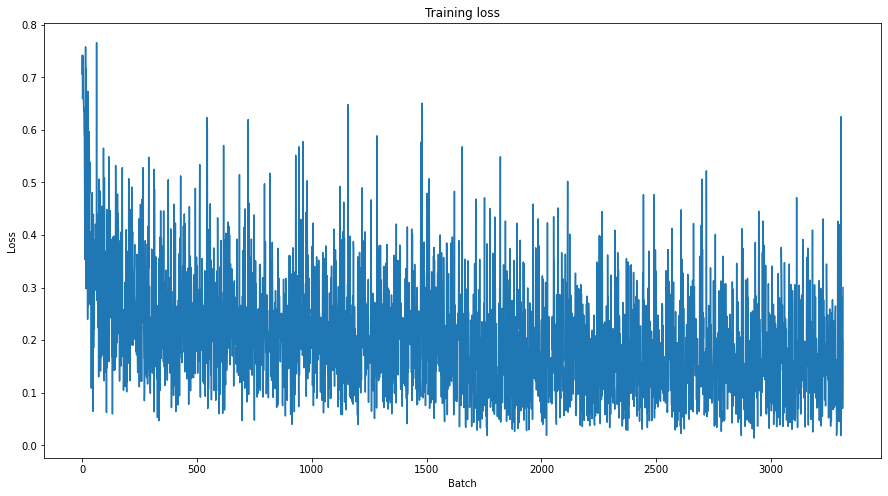

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#모델 저장, 불러오기

In [0]:
# torch.save(model.state_dict(),'/content/drive/My Drive/model_netflix_82400_binary_epoch2_maxlen128_edit.pth')

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",      #원래클래스 지정, 내부 파라미터 같은걸 불러오는것이기에 클래스 지정 안하면 사용 못함
                                                      num_labels=2)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/netflix_review_project/model_netflix_82400_binary_epoch2_maxlen128_edit.pth'))         
model.cuda()                                                                    #GPU 지정 같은 느낌

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

# Test

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/test_netflix_82400_binary_edit.csv")
test.dropna(inplace=True)
test['Sentiment'] = test.Sentiment.astype(int)

test_id = test['SentenceId']
test_phrase = test['Phrase']
labels = test.Sentiment.values

In [0]:
test

SentenceId                                             Phrase  Sentiment
0           58897  Says can't connect to server 1001 using Google...          0
1           58898  It keeps loading it will not let me get it and...          1
2           58899  I personally Hate when the American Netflix ha...          0
3           58900     There are lots of fun things to watch and do !          1
4           58901  Netflix is great its just i wish you had the d...          1
...           ...                                                ...        ...
14718       73615                            I fricken love this app          1
14719       73616                                   its is very good          1
14720       73617  hey good shows to get would be the 90s kids sh...          1
14721       73618                works good dont have any problems..          1
14722       73619  i love Netflix its perfect to watch your fav e...          1

[14723 rows x 3 columns]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)#이후 트레인때와 같은 방식으로 데이터 처리
sentences = test.Phrase.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [0]:
MAX_LEN = 128
length_edit=[]
for tokenized_text in tokenized_texts:
  if len(tokenized_text) >MAX_LEN-1:
    cut=tokenized_text[:MAX_LEN-1]
    cut.append(tokenized_text[-1])
    length_edit.append(cut)
  else:
    length_edit.append(tokenized_text)
tokenized_texts=length_edit

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

In [0]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

In [0]:
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)                         #순차적으로 인덱스 샘플해서 출력, Randomsampler 와 다른건 TEST셋을 순서대로 평가하기 위해
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# 평가 모드로 전환
model.eval()

# 추적 변수 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)                                    # batch를 GPU로
  
  b_input_ids, b_input_mask, b_labels = batch                                   # Dataloader에서 값 끌고오기
  with torch.no_grad():                                                         # gradients 계산하거나 저장하게 하지 않음으로써 메모리 절약과 평가속도 향상
    # 순전파
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # 나온 값을 CPU로 이동
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 예측확률값 저장
  predictions.append(logits)                           

In [0]:
preds = np.concatenate(predictions)                                             #32개씩 한꺼번에 묶여있는 값들 합치기
pred_labels = np.argmax(preds, axis =1)                                         #가장 class 확률이 높은 것의 index= 점수

In [0]:
submission_binary_edit = pd.DataFrame({'PhraseId': test_id, 'Phrase': test_phrase, 'Pred_Sentiment': pred_labels,'Real_Sentiment':labels})
submission_binary_edit.to_csv("/content/drive/My Drive/submission_netflix_binary_maxlen128_edit.csv", index=False)
submission_binary_edit.head(10)

PhraseId  ... Real_Sentiment
0     58897  ...              0
1     58898  ...              1
2     58899  ...              0
3     58900  ...              1
4     58901  ...              1
5     58902  ...              1
6     58903  ...              1
7     58904  ...              1
8     58905  ...              1
9     58906  ...              0

[10 rows x 4 columns]

## submission 파일 읽기

In [0]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/submission_netflix_binary_maxlen128_edit.csv")

In [0]:
submission.head()

PhraseId  ... Real_Sentiment
0     58897  ...              0
1     58898  ...              1
2     58899  ...              0
3     58900  ...              1
4     58901  ...              1

[5 rows x 4 columns]

Normalized confusion matrix


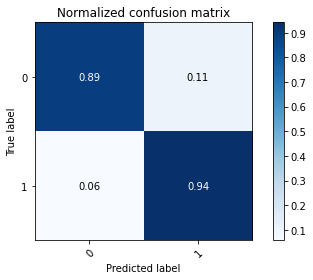

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):

    title ='Normalized confusion matrix'
    cm = confusion_matrix(y_true, y_pred)    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
               ax.text(j, i, format(cm[i, j], fmt),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(submission['Real_Sentiment'], submission['Pred_Sentiment'], classes=[0, 1])

In [0]:
print("모델의 정확도 :%.6f\n모델의 RMSE :%.6f" %(accuracy_score(submission['Pred_Sentiment'], submission['Real_Sentiment']),mean_squared_error(submission['Pred_Sentiment'], submission['Real_Sentiment'])**0.5))

모델의 정확도 :0.927121
모델의 RMSE :0.269961


# WORD CLOUD

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/train_netflix_82400_binary_edit.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/test_netflix_82400_binary_edit.csv")
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/submission_netflix_binary_maxlen128_edit.csv")

In [0]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image
import re
import matplotlib.pyplot as plt

# Data Cleaning

In [0]:
train['Phrase'] = train['Phrase'].str.lower()
test['Phrase'] = test['Phrase'].str.lower()
submission['Phrase'] = submission['Phrase'].str.lower()

In [0]:
words = ['watch','netflix','love', 'movie','movies', 'good', 'hate','gets','show', 'hey','great','app','find', 'full', 'one', 'want', 'will']

def remove_word(text,word_to_remove):
    word = re.compile(word_to_remove)
    return word.sub('', text)

text = "I watch netflix"
for word in words:
    text = remove_word(text, word)
print(text)

I  


In [0]:
for word in words:
    train['Phrase']=train['Phrase'].apply(lambda x: remove_word(x, word))

for word in words:
    test['Phrase']=test['Phrase'].apply(lambda x: remove_word(x, word))

for word in words:
    submission['Phrase']=submission['Phrase'].apply(lambda x: remove_word(x, word))

## Train 셋의 word cloud 분포

In [0]:
high_rate_review = train[train['Sentiment'] ==1]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = train[train['Sentiment'] ==0]['Phrase']
low_rating_document = low_rate_review.values

Text(0.5, 1.0, 'Low rate review')

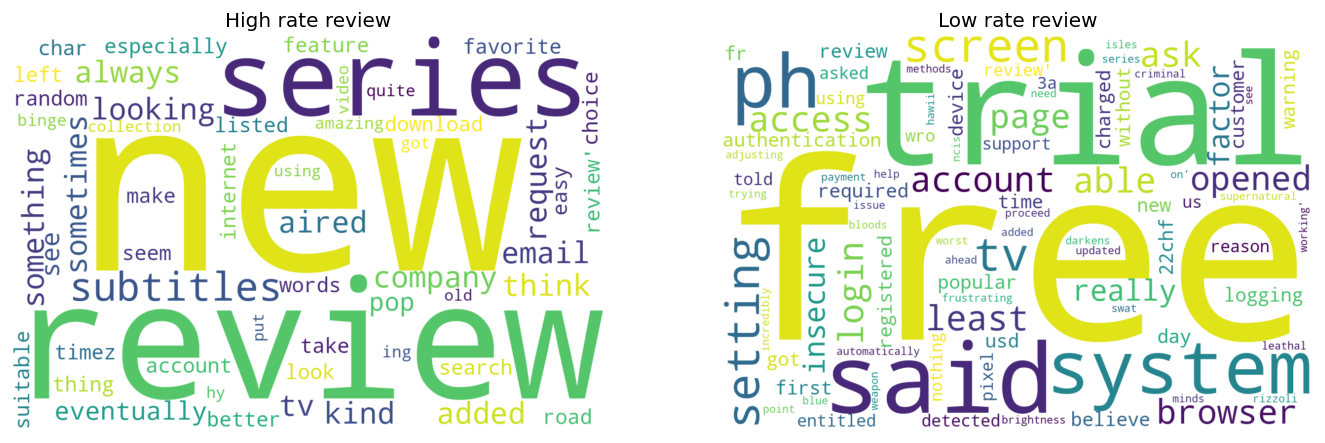

In [0]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")

## Test 셋의 word cloud 분포

In [0]:
high_rate_review = submission[submission['Real_Sentiment'] ==1]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = submission[submission['Real_Sentiment'] ==0]['Phrase']
low_rating_document = low_rate_review.values

Text(0.5, 1.0, 'Low rate review')

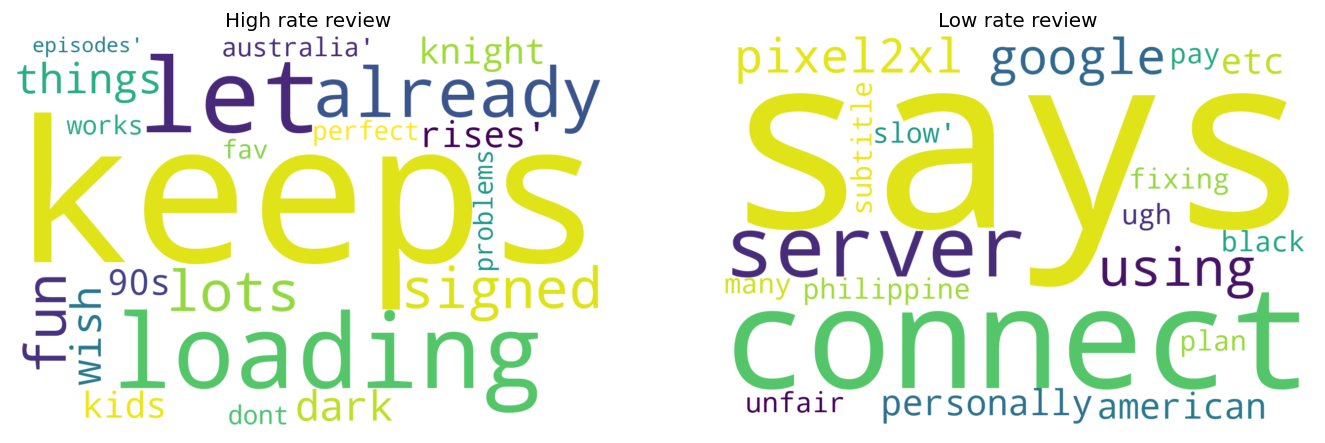

In [0]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")

## Test 셋으로 예측한 word cloud 분포

In [0]:
high_rate_review = submission[submission['Pred_Sentiment'] ==1]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = submission[submission['Pred_Sentiment'] ==0]['Phrase']
low_rating_document = low_rate_review.values

Text(0.5, 1.0, 'Low rate review')

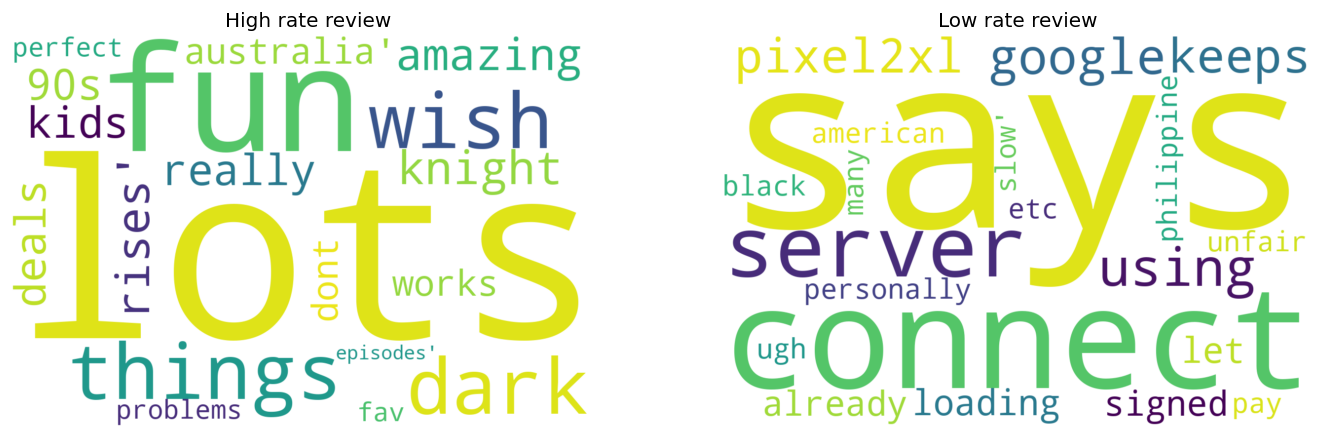

In [0]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")